## DEFINE THE SETUP

First of all check that you are running the notebook in the correct environment.

We start by importing the libraries we need for the analysis.

In [1]:
# Import the packages required for this tutorial

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from functools import partial

from scipy.special import erfc

from classy import Class
from py21cmfast.inputs import global_params 
import py21cmfast as p21c

We define the cosmological parameters we need in our run.

In [2]:
cosmo_params_fNL = {"hlittle": 0.6736, # hubble parameter
                "OMb": 0.0493, # baryon density
                "OMm": 0.3153, # matter (CDM+baryon) density
                "A_s": 2.1e-9, # amplitude of the primordial fluctuations
                "POWER_INDEX": 0.9649, # spectral index of the primordial spectrum
                "tau_reio": 0.0544, # optical depth to reionization
                "F_NL":300., # LOCAL NON GAUSSIANITY
                }

Define the quantities needed in our run.

In [3]:
log10_M_array = np.linspace(4.,20.,300)
rho_crit = 2.7754e11 * cosmo_params_fNL['hlittle']**2
rhoM = rho_crit* cosmo_params_fNL['OMm']
FNL = 300 

We run the code CLASS to computes the matter transfer function.

In [4]:
CLASS_params = {}
CLASS_params['h'] = cosmo_params_fNL['hlittle']
CLASS_params['Omega_cdm'] = cosmo_params_fNL['OMm'] - cosmo_params_fNL['OMb']
CLASS_params['Omega_b'] = cosmo_params_fNL['OMb']
CLASS_params['A_s'] = cosmo_params_fNL['A_s']
CLASS_params['n_s'] = cosmo_params_fNL['POWER_INDEX']
CLASS_params['output'] = 'tCl,pCl,lCl,mTk,vTk,mPk'
CLASS_params['lensing'] = 'yes'
CLASS_params['z_pk'] = 1087.
CLASS_params['l_max_scalars'] = 3000
# We need to run CLASS for very large wavenumbers. This is required for computing sigma(M) and the HMF
CLASS_params['P_k_max_1/Mpc'] = 1200.

# Run CLASS!
CLASS_OUTPUT = Class()
CLASS_OUTPUT.set(CLASS_params)
CLASS_OUTPUT.compute()

Transfer_0 = CLASS_OUTPUT.get_transfer(z=0.)
k_CLASS = Transfer_0['k (h/Mpc)'][:]*cosmo_params_fNL['hlittle'] # 1/Mpc
delta_m_0_CLASS = Transfer_0['d_tot'][:]
k_output = pow(10.,np.array(global_params.LOG_K_ARR_FOR_TRANSFERS)) # 1/Mpc
delta_m_0 = p21c.generate_ICs.Interpolate_transfer(delta_m_0_CLASS,k_CLASS,k_output)

## DEFINE THE FUNCTIONS NEEDED IN THE RUN

We define three point functions needed to model the non Gaussian corrections to $f_{\rm coll}$. The goal is to compute $\langle \delta_n^3\rangle$, $\langle \delta_m^3\rangle$, $\langle \delta_n\delta_m^2\rangle$, $\langle \delta_n^2\delta_m\rangle$ under the condition $M_n < M_m$; to do so, we implement a function that computes $\langle \delta_n\delta_m^2\rangle$ and then we will use it to tabulate a $M_n\times M_m$ matrix in which $\langle \delta_n\delta_m^2\rangle$ is the upper triangular part, $$\langle \delta_n^3\rangle$ and $\langle\delta_m^3\rangle$ are estimated on the diagonal $m=n$, and $\langle \delta_n^2\delta_m\rangle$ is described by the lower triangular part under the transformation $n\to m$. 
We also want to implement the derivatives of all the three point functions with respect to $d/dM_n$.
Note that these matrices are non symmetric.

First we define a function to compute 
$$     \mathcal{F}^{\rm local}(k_1,M_m,k_{\rm cutoff},f_{NL}) = \frac{2f_{NL}}{8\pi^4}\mathcal{T}_m(k_1)\int_{k_{cutoff}}{d{k}_2}\,k_2^2 W_m(k_2)\mathcal{T}_m(k_2) \times $$
$$\times \int d\mu W_m(k_1,k_2,\mu)\mathcal{T}_m(k_1,k_2,\mu)[P_\Phi(k_1)P_\Phi(k_2)+P_\Phi(k_1)P_\Phi(k_1,k_2,\mu)+P_\Phi(k_2)P_\Phi(k_1,k_2,\mu)]$$


and we compute the derivative with respect to $M_m$, which we will then need to transform through $m\to n$
$$\frac{d\mathcal{F}^{\rm local}(k_1,M_m,k_{\rm cutoff},f_{NL})}{dM_m} = \frac{2f_{NL}}{8\pi^4}\mathcal{T}_m(k_1)\int_{k_{\rm cutoff}}{d{k}_2}\,k_2^2\mathcal{T}_m(k_2)  \times $$
$$\times \int d\mu \left[\frac{dW_m(k_2)}{dM_{m}}W_m(k_1,k_2,\mu)+W_m(k_2)\frac{dW_m(k_1,k_2,\mu)}{dM_{m}}\right]\times$$

$$ \times \mathcal{T}_m(k_1,k_2,\mu)[P_\Phi(k_1)P_\Phi(k_2)+P_\Phi(k_1)P_\Phi(k_1,k_2,\mu)+P_\Phi(k_2)P_\Phi(k_1,k_2,\mu)]$$

In [5]:
def FM(kv,MassVector,cosmo_params,global_params,kcutoff,fnl):

    rho_crit = 2.7754e11 * cosmo_params['hlittle']**2
    rhoM = rho_crit* cosmo_params['OMm']

    Mm = MassVector[None,None,:]
    Rm = (3.*Mm/(4.*np.pi*rhoM))**(1/3.)

    kall = pow(10.,np.array(global_params.LOG_K_ARR_FOR_TRANSFERS)) # 1/Mpc
    k = np.asarray(kall[[kall > kcutoff][0]])
    mu = np.linspace(-0.995, 0.995, 128) # cos theta

    k_2 = k[:, None, None]
    mu_val = mu[None,:,None]

    P_k1 =  9/25. * (2*np.pi**2/kv**3) * cosmo_params['A_s'] * (kv/0.05)**(cosmo_params['POWER_INDEX'] - 1.) # 9/25 is already in the transfer function from CLASS
    P_k2 =  9/25. * (2*np.pi**2/k_2**3) * cosmo_params['A_s'] * (k_2/0.05)**(cosmo_params['POWER_INDEX'] - 1.) # 9/25 is already in the transfer function from CLASS

    x2 = k_2*Rm
    Wm_k2 = 3.0*(np.sin(x2) - x2*np.cos(x2))/(x2)**3  # dimension k1, k2, mu, Mn, Mm
    dWm_k2 = (3 / np.power(x2, 2) * np.sin(x2) - 9 / np.power(x2, 4) * (np.sin(x2) - x2 * np.cos(x2))) * (x2) / (3 * Mm)

    k_CLASS = Transfer_0['k (h/Mpc)'][:]*cosmo_params['hlittle'] # 1/Mpc
    delta_m_0_CLASS = - 5/3. * Transfer_0['d_tot'][:]
    Tm_k1 = interp1d(k_CLASS, delta_m_0_CLASS, kind='cubic', bounds_error=False,fill_value=0.)(kv)
    Tm_k2 = interp1d(k_CLASS, delta_m_0_CLASS, kind='cubic', bounds_error=False,fill_value=0.)(k_2)

    k_12 = np.sqrt(pow(kv,2)+pow(k_2,2) + 2*kv*k_2*mu_val)
     
    Tm_k12 = interp1d(k_CLASS, delta_m_0_CLASS, kind='cubic', bounds_error=False,fill_value=0.)(k_12)

    x12 = k_12 * (3.*MassVector[None,None,:]/(4.*np.pi*rhoM))**(1/3.)
    sin_x12 = np.sin(x12)
    cos_x12 = np.cos(x12)
    Wm_k12 = 3.0*(sin_x12 - x12*cos_x12)/(x12)**3

    dWm_k12 =  (3 / np.power(x12, 2) * np.sin(x12) - 9 / np.power(x12, 4) * (np.sin(x12) - x12 * np.cos(x12))) * (x12) / (3 * Mm)

    P_k12 =  9/25. * (2*np.pi**2/k_12**3) * cosmo_params['A_s'] * (k_12/0.05)**(cosmo_params['POWER_INDEX'] - 1.)

    integrand = k_2**2 * Wm_k2 * Tm_k2 * Wm_k12 * Tm_k12 * (P_k1 * P_k2 + P_k2 * P_k12 + P_k1 * P_k12)
    
    integral_dk2 = np.trapz(integrand, k, axis = 0)
    Fm = np.trapz(integral_dk2, mu, axis = 0)

    Fm *= 2. * fnl / (8*np.pi**4.) * Tm_k1

    integrand_dn2 = k_2**2 * Tm_k2 * Tm_k12 * (P_k1 * P_k2 + P_k2 * P_k12 + P_k1 * P_k12) * (dWm_k2 * Wm_k12 + Wm_k2 * dWm_k12)
    
    integral_dk2_dn2 = np.trapz(integrand_dn2, k, axis = 0)
    dFm_dn2 = np.trapz(integral_dk2_dn2, mu, axis = 0)
    
    dFm_dn2 *= 2. * fnl / (8*np.pi**4.) * Tm_k1

    return [Fm, dFm_dn2]


Now we use the previous function to compute

$$\langle \delta_n\delta_m^2\rangle(M_n,M_m,k_{\rm cutoff},f_{NL}) = \int_{k_{cutoff}}{dk_1}\,k_1^2W_n(k_1)\mathcal{F}^{\rm local}(k_1,M_m,k_{\rm cutoff},f_{NL})$$

and the derivative with respect to $M_n$, which will assume three different expressions on the diagonal and upper / lower triangular parts of the matrix

if $n = m$ (diagonal)
$$\frac{d\langle \delta_n^3\rangle}{dM_n}(M_n,M_m,k_{\rm cutoff},f_{NL}) = \int{dk_1}\,k_1^2\left[W_n(k_1)\frac{d\mathcal{F}^{\rm local}}{dM_n}+\frac{dW_n(k_1)}{dM_n}\mathcal{F}^{\rm local}\right]$$

if $m > n$ (upper triangular)
$$\frac{d\langle \delta_n\delta_m^2\rangle}{dM_n}(M_n,M_m,k_{\rm cutoff},f_{NL}) = \int{dk_1}\,k_1^2\left[\frac{dW_n(k_1)}{dM_n}\mathcal{F}^{\rm local}\right]$$

if $m < n$ (lower triangular)
$$\frac{d\langle \delta_n^3\rangle}{dM_n}(M_n,M_m,k_{\rm cutoff},f_{NL}) = \int{dk_1}\,k_1^2\left[W_n(k_1)\frac{d\mathcal{F}^{\rm local}}{dM_n}\right]$$

Finally, we will set ${d\langle \delta_m^3\rangle}/{dM_n} = 0$.

In [6]:
def tpf(MassVector,cosmo_params,global_params,kcutoff,fnl):

    kall = pow(10.,np.array(global_params.LOG_K_ARR_FOR_TRANSFERS)) # 1/Mpc
    k = np.asarray(kall[[kall > kcutoff][0]])

    rho_crit = 2.7754e11 * cosmo_params['hlittle']**2
    rhoM = rho_crit* cosmo_params['OMm']    
    
    k_1 = k[:,None]

    FM_function = lambda kv: FM(kv,MassVector=MassVector,cosmo_params=cosmo_params,global_params=global_params,kcutoff=kcutoff,fnl=fnl)
    temp = np.apply_along_axis(FM_function, axis=-1, arr=k_1)
    Fm = temp[:,0,:][:,None,:]
    dFm_dn2 = temp[:,1,:][:,None,:]

    k_1 = k[:,None,None]
    Mn = MassVector[None,:,None]
    Rn = (3.*Mn/(4.*np.pi*rhoM))**(1/3.)
    x1 = k_1*Rn
    Wn_k1 = 3.0*(np.sin(x1) - x1*np.cos(x1))/(x1)**3 
    dWn_k1 = (3 / np.power(x1, 2) * np.sin(x1) - 9 / np.power(x1, 4) * (np.sin(x1) - x1 * np.cos(x1))) * (x1) / (3 * Mn)
    integrand = k_1 ** 2 * Wn_k1 * Fm

    ddd = np.trapz(integrand,k,axis=0)

    integrand_dnm2 = k_1 ** 2 * dWn_k1 * Fm
    integrand_dmn2 = k_1 ** 2 * Wn_k1 * dFm_dn2
    integrand_dn3 = k_1 ** 2 * (dWn_k1 * Fm + Wn_k1 * dFm_dn2)

    der_dnm2 = np.trapz(integrand_dnm2,k,axis=0)
    der_dmn2 = np.trapz(integrand_dmn2,k,axis=0)
    der_dn3 = np.trapz(integrand_dn3,k,axis=0)

    der_ddd = np.zeros((len(MassVector),len(MassVector)))
    # Fill below the diagonal (i > j) with n2m
    der_ddd[np.tril_indices(len(MassVector), -1)] = der_dmn2[np.tril_indices(len(MassVector), -1)]

    # Fill above the diagonal (i < j) with nm2
    der_ddd[np.triu_indices(len(MassVector), 1)] = der_dnm2[np.triu_indices(len(MassVector), 1)]

    # Fill the diagonal with nnn
    np.fill_diagonal(der_ddd, np.diagonal(der_dn3))

    return ddd, der_ddd

At this point we implement the $f_{\rm coll}$ functions defined in D'Alosio and in Lidz. Both the functions return the Gaussian term and the non Gaussian corrections separately.

In [7]:
def fcoll_DALOSIO(M1_id,M2_id,tpf,z, delta2):

    M1 = 10**log10_M_array[M1_id]
    M2 = 10**log10_M_array[M2_id]
    
    Rn = (3.*M1/(4.*np.pi*rhoM))**(1/3.)
    Rm = (3.*M2/(4.*np.pi*rhoM))**(1/3.)

    sigma1 = CLASS_OUTPUT.sigma(Rn,0.)
    sigma2 = CLASS_OUTPUT.sigma(Rm,0.)

    growthf = CLASS_OUTPUT.scale_independent_growth_factor(z)
    delta1 = 1.68
    sigma1 = sigma1*sigma1
    sigma2 = sigma2*sigma2
    if delta2 == False:     
        delta2 = np.sqrt(sigma2) * growthf # this is the condition required by Fig. 2 in D'Alosio

    deltagrowth_diff = ( delta1 - delta2 )/growthf
    if (sigma1 < sigma2):
        return 0.,0.
    elif (sigma1 > sigma2):
        sigma_diff = sigma1 - sigma2
    elif (sigma1==sigma2):
        sigma_diff = 1.e-6
        
    fcoll_dMmin_EPS = erfc((deltagrowth_diff)/np.sqrt( 2.*sigma_diff ) )

    delta_n3 = tpf[M1_id,M1_id]
    delta_m3 = tpf[M2_id,M2_id] 
    delta_m2delta_n = tpf[M1_id,M2_id]
    delta_mdelta_n2 = tpf[M2_id,M1_id]

    A = (delta_n3 - delta_m3 + 3.*delta_m2delta_n - 3.*delta_mdelta_n2)
    B = (delta_m3 + delta_mdelta_n2 - 2*delta_m2delta_n)
    Cval = (delta_m2delta_n - delta_m3)

    dfcoll_G_dSn = deltagrowth_diff / np.sqrt(2*np.pi) / pow(sigma_diff,3/2.) * np.exp(-pow(deltagrowth_diff,2)/2./sigma_diff); 

    val = ( pow(delta1 / growthf, 2) - delta1 * delta2 / pow(growthf,2)) / sigma2 ; 
    cothD = (np.exp(val) + np.exp(-val)) / (np.exp(val) - np.exp(-val)); 

    one_dSn = A/3. * (
         deltagrowth_diff / sigma_diff - 1./deltagrowth_diff )* dfcoll_G_dSn

    two_dSn = B/sigma2 * ( delta1 / growthf - deltagrowth_diff * cothD ) * dfcoll_G_dSn 

    three_dSn = Cval*sigma_diff/(pow(sigma2,2) * deltagrowth_diff ) * (pow(delta2 / growthf, 2.) - sigma2 - 2. * (pow(delta1 / growthf,2)-delta1*delta2/pow(growthf,2)) * (cothD -1.)) * dfcoll_G_dSn  

    if (delta1 <= delta2 or pow(delta1/growthf,2) < sigma2 or sigma2 == 0.):
        fcoll_dMmin_NG = 0.
    else:
        fcoll_dMmin_NG = (one_dSn + two_dSn + three_dSn)
    
    return fcoll_dMmin_EPS , fcoll_dMmin_NG 

In [8]:
def fcoll_LIDZ(M1_id,M2_id,tpf,z, delta2):

    M1 = 10**log10_M_array[M1_id]
    M2 = 10**log10_M_array[M2_id]
    sigma1 = CLASS_OUTPUT.sigma((3.*M1/(4.*np.pi*rhoM))**(1/3.),0.)
    sigma2 = CLASS_OUTPUT.sigma((3.*M2/(4.*np.pi*rhoM))**(1/3.),0.)

    growthf = CLASS_OUTPUT.scale_independent_growth_factor(z)
    delta1 = 1.68
    sigma1 = sigma1*sigma1
    sigma2 = sigma2*sigma2
    if delta2 == False:     
        delta2 = np.sqrt(sigma2) * growthf # this is the condition required by Fig. 2 in D'Alosio

    deltagrowth_diff = ( delta1 - delta2 )/growthf
    if (sigma1 < sigma2):
        return 0.,0.
    elif (sigma1 > sigma2):
        sigma_diff = sigma1 - sigma2
    elif (sigma1==sigma2):
        sigma_diff = 1.e-6
        
    fcoll_dMmin_EPS = erfc((deltagrowth_diff)/np.sqrt( 2.*sigma_diff ) )

    delta_n3 = tpf[M1_id,M1_id]
    delta_m3 = tpf[M2_id,M2_id] 
    delta_m2delta_n = tpf[M1_id,M2_id]
    delta_mdelta_n2 = tpf[M2_id,M1_id]

    A = (delta_n3 - delta_m3 + 3.*delta_m2delta_n - 3.*delta_mdelta_n2)
    B = (delta_m3 + delta_mdelta_n2 - 2*delta_m2delta_n)

    if (delta1 <= delta2 or pow(delta1/growthf,2) < sigma2 or sigma2 == 0.):
        fcoll_dMmin_NG = 0.
    else:
        fcoll_dMmin_NG = np.exp(-pow(deltagrowth_diff,2)/2./sigma_diff) * (A / 3./np.sqrt(2*np.pi)/sigma_diff**(3/2.)*(deltagrowth_diff**2/sigma_diff - 1.)+ B*delta2/growthf/sigma2*deltagrowth_diff/np.sqrt(2*np.pi)/sigma_diff**(3/2.))
        

    return fcoll_dMmin_EPS , fcoll_dMmin_NG 


## PERFORM THE RUN AND COMPUTE THE VALUES 

First we test the three point functions. 

We tabulate the $\langle \delta_n\delta_m^2\rangle$ and  $d\langle \delta_n\delta_m^2\rangle/dM_n$ matrices and the $\langle\delta_n^3\rangle$ array. We also compute $\sigma_{n,m}^2$ using CLASS.

In [9]:
nmm_fast, der_nmm_fast = tpf(pow(10.,log10_M_array),cosmo_params_fNL,global_params,kcutoff=0.01,fnl=FNL)

nnn_fast = np.zeros((len(log10_M_array)))
der_nnn_fast = np.zeros((len(log10_M_array)))
sigma_0_fast = np.zeros((len(log10_M_array)))

for Mn_ind, Mn in enumerate(pow(10.,log10_M_array)):
    nnn_fast[Mn_ind] = nmm_fast[Mn_ind,Mn_ind]
    der_nnn_fast[Mn_ind] = der_nmm_fast[Mn_ind,Mn_ind]
    sigma_0_fast[Mn_ind] = CLASS_OUTPUT.sigma((3.*Mn/(4.*np.pi*rhoM))**(1/3.),0.)

We compare our three point functions with Fig. 1 in D'Alosio to verify the implementation.

(0.0, 10.0)

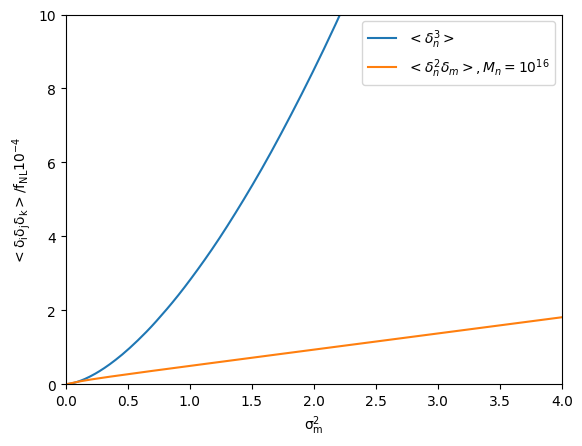

In [10]:
id = 225 # choose Mn - this is the index in the mass array 

plt.plot(sigma_0_fast**2,nnn_fast/FNL/1e-4 ,label=r'$<\delta_n^3>$')
plt.plot(sigma_0_fast**2,nmm_fast[id,:]/FNL/1e-4,label=r'$<\delta_n^2\delta_m>,M_n = 10^{%g}$'%round(log10_M_array[id],1))
plt.xlabel(r'$\rm \sigma^2_m$')
plt.ylabel(r'$\rm <\delta_i\delta_j\delta_k>/f_{NL}10^{-4}$')
plt.legend()
plt.xlim(0,4)
plt.ylim(0,10)

Now we want to test the $f_{\rm coll}$ and to compare the two prescriptions in D'Alosio and Lidz. 

We first compute $f_{\rm coll}$ for a fixed value of $M_m$ and as a function of $M_n$. We start by setting $\delta_m = \sqrt{S_m}$ as it is written in the caption of Fig. 2 by D'Alosio.  

In [11]:
Mm_ind = 225 # choose Mm - this is the index in the mass array 

funct = lambda Mv: fcoll_LIDZ(Mv,Mm_ind,nmm_fast,z=0.,delta2 = False)
functDA = lambda Mv: fcoll_DALOSIO(Mv,Mm_ind,nmm_fast,z=0., delta2 = False)
fcoll_gauss = np.zeros((len(log10_M_array)))
fcoll_L_NONgauss = np.zeros((len(log10_M_array)))
fcoll_DA_NONgauss = np.zeros((len(log10_M_array)))
for i in range(len(log10_M_array)):
    temp = funct(i)
    fcoll_gauss[i] = temp[0]
    fcoll_L_NONgauss[i] = temp[1]
    temp = functDA(i)
    fcoll_DA_NONgauss[i] = temp[1]

We now compare with Fig. 2 in D'Alosio.

/tmp/ipykernel_38223/692578783.py:12: RuntimeWarning: invalid value encountered in divide
  plt.semilogx(pow(10,log10_M_array) ,(fcoll_gauss+fcoll_DA_NONgauss)/fcoll_gauss)
/tmp/ipykernel_38223/692578783.py:13: RuntimeWarning: invalid value encountered in divide
  plt.semilogx(pow(10,log10_M_array),(fcoll_gauss+fcoll_L_NONgauss)/fcoll_gauss,ls = '--')


Text(0, 0.5, '($f^G_{coll}+f^{NG}_{coll}) / f^G_{coll}$')

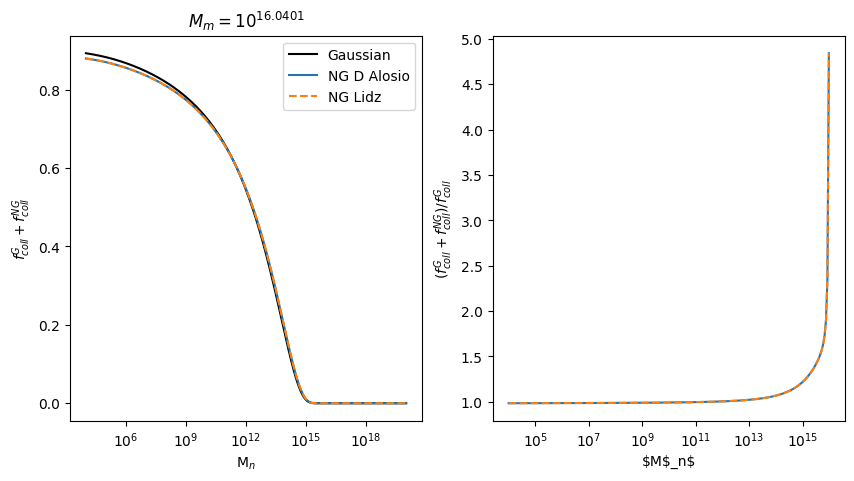

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.semilogx(pow(10,log10_M_array),(fcoll_gauss),'k-',label='Gaussian')
plt.semilogx(pow(10,log10_M_array),(fcoll_gauss + fcoll_DA_NONgauss),label='NG D Alosio')
plt.semilogx(pow(10,log10_M_array),(fcoll_gauss+ fcoll_L_NONgauss),ls = '--',label = 'NG Lidz')
plt.xlabel(r'M$_n$')
plt.ylabel(r'$f^G_{coll}+f^{NG}_{coll}$')
plt.legend(loc=1)
plt.title(r'$M_m=10^{%g}$'%log10_M_array[Mm_ind])

plt.subplot(122)
plt.semilogx(pow(10,log10_M_array) ,(fcoll_gauss+fcoll_DA_NONgauss)/fcoll_gauss)
plt.semilogx(pow(10,log10_M_array),(fcoll_gauss+fcoll_L_NONgauss)/fcoll_gauss,ls = '--')
plt.xlabel(r'$M$_n$')
plt.ylabel(r'($f^G_{coll}+f^{NG}_{coll}) / f^G_{coll}$')

NEXT STEPS:
- compare $f_{\rm coll}$ in D'Alosio and Lidz for different $M_m, \delta_m, z$... and verify the goodness of Lidz's approximation
- implement $df_{\rm coll}/dM_n$ in the two formalisms
- verify if the approximation holds also in the case of $df_{\rm coll}/dM_n$